In [43]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

In [44]:
edges           = pd.read_csv('../data/edges_191120.csv')
nodes           = pd.read_csv('../data/nodes_191120.csv', index_col=0)
ingr2cat        = pd.read_csv('../data/dict_ingr2cate.csv')
embeddings_dict = pickle.load(open('../data/FlavorGraph_Node_Embedding.pickle', 'rb'))

id_to_name = dict(zip(nodes.index, nodes['name']))

ingredients_idx = nodes[nodes['node_type']=='ingredient'].index.tolist()
nodes           = nodes.loc[ingredients_idx]#.reset_index(drop=True)
embeddings_dict = {k: embeddings_dict[k] for k in map(str, ingredients_idx)}

In [45]:
G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['id_1'], row['id_2'], weight=row['score'], type=row['edge_type'])
for node_id, row in nodes.iterrows():
    G.add_node(node_id, name=row['name'], node_type=row['node_type'], is_hub=row['is_hub'])

In [46]:
edges[(edges['id_1']==1263) | (edges['id_2']==1263)]

,id_1,id_2,score,edge_type
476,1263,4005,0.230688,ingr-ingr
742,1263,3763,0.140601,ingr-ingr
789,1263,4184,0.133273,ingr-ingr
816,1263,2508,0.158040,ingr-ingr
2455,1263,3685,0.117946,ingr-ingr
...,...,...,...,...
132326,1263,7623,NaN,ingr-fcomp
132327,1263,8378,NaN,ingr-fcomp
132328,1263,8446,NaN,ingr-fcomp
132329,1263,8302,NaN,ingr-fcomp


In [47]:
subset = nodes[nodes['name'].str.contains('radish', case=False, na=False)]
# subset = subset[subset['is_hub'] == 'hub']
subset

,name,id,node_type,is_hub
node_id,,,,
1712,creamed_horseradish,NaN,ingredient,no_hub
1795,daikon_radish,NaN,ingredient,no_hub
2508,fresh_horseradish,NaN,ingredient,no_hub
3312,horseradish,NaN,ingredient,hub
3313,horseradish_cream,NaN,ingredient,no_hub
3314,horseradish_mustard,NaN,ingredient,no_hub
3315,horseradish_root,NaN,ingredient,no_hub
3316,horseradish_sauce,NaN,ingredient,no_hub
5071,prepared_horseradish,NaN,ingredient,no_hub


In [58]:
food_id = 5183#1263
food_name = id_to_name[food_id]
neighbors = [n for n in G.neighbors(food_id) if n in nodes.index]

In [59]:
main_food = embeddings_dict[str(food_id)]
# get cloest neighbors based on embeddings
neighbor_embeddings = np.array([embeddings_dict[str(n)] for n in neighbors])
similarities = cosine_similarity([main_food], neighbor_embeddings)[0]
# sort neighbors by similarity
sorted_neighbors = [n for _, n in sorted(zip(similarities, neighbors), reverse=True)]
# get names of sorted neighbors
sorted_neighbor_names = [id_to_name[n] for n in sorted_neighbors]
sorted_neighbor_names

['sugar_snap_pea',
 'white_hominy',
 'gem_lettuce',
 'oil_cured_olive',
 'romaine_lettuce_heart',
 'stick',
 'hominy',
 'tuna_packed_in_oil',
 'japanese_cucumber',
 'snap_pea',
 'baby_turnip',
 'seedless_cucumber',
 'pumpernickel_bread',
 'cracked_farro',
 'pea_pod',
 'refried_black_bean',
 'ricotta_salata',
 'hardboiled_egg',
 'bibb_lettuce',
 'fleur_de_sel',
 'persian_cucumber',
 'boston_lettuce_leaf',
 'red_radish',
 'hearts_of_palm',
 'english_cucumber',
 'head_romaine_lettuce',
 'kirby_cucumber',
 'frozen_lima_bean',
 'english_pea',
 'curly_endive_lettuce',
 'head_iceberg_lettuce',
 'english_seedless_cucumber',
 'avocado_oil',
 'french_dressing',
 'dried_guajillo_chilies',
 'radish_sprout',
 'watercress_leaf',
 'mixed_green',
 'horseradish_sauce',
 'green_leaf_lettuce',
 'chicory_lettuce',
 'greek_olive',
 'flat_bread',
 'fat_free_italian_salad_dressing',
 'boston_lettuce',
 'mesclun',
 'cooked_pork',
 'iceberg_lettuce',
 'belgian_endive',
 'red_leaf_lettuce',
 'ground_sumac',
 'l

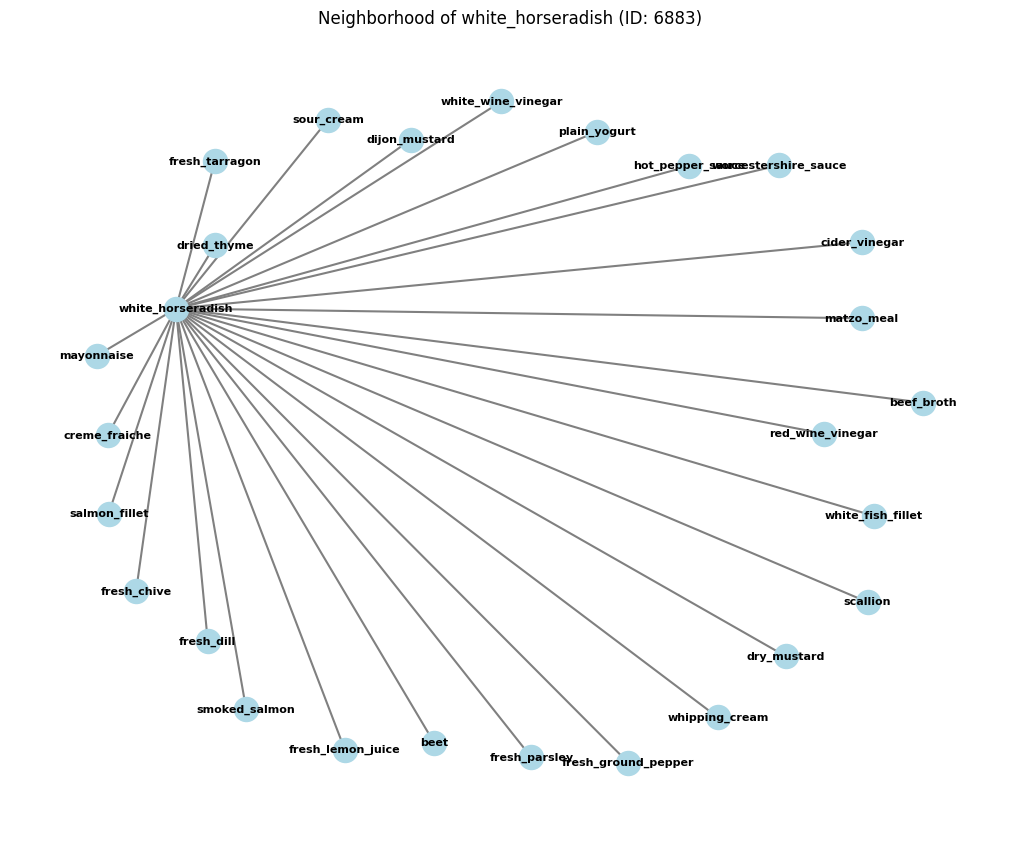

In [50]:
Gsub = G.subgraph([food_id] + neighbors)
# Only keep hub nodes
hub_neighbors = [n for n in neighbors if G.nodes[n].get('is_hub') == 'no_hub']
Gsub = G.subgraph([food_id] + hub_neighbors)

# Only keep edges connected to the main node
Gsub_filtered = nx.Graph()
Gsub_filtered.add_nodes_from(Gsub.nodes(data=True))
for u, v, data in Gsub.edges(data=True):
    if u == food_id or v == food_id:
        Gsub_filtered.add_edge(u, v, **data)

pos = nx.spring_layout(Gsub_filtered, seed=42, weight='weight', k=2)

plt.figure(figsize=(10, 8))
nx.draw(
    Gsub_filtered,
    pos,
    with_labels=True,
    labels=nx.get_node_attributes(Gsub_filtered, 'name'),
    node_size=300,
    node_color='lightblue',
    font_size=8,
    font_weight='bold',
    edge_color='gray',
    width=1.5
)
plt.title(f'Neighborhood of {food_name} (ID: {food_id})')
plt.axis('off')
plt.show()

